In [1]:
import numpy as np
import pandas as pd
import sys

from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/Users/clemens/Documents/Code/AnalysisToolbox")

import spikeAnalysisToolsV2.data_loading as data
import spikeAnalysisToolsV2.synapse_analysis as synapse_analysis
import spikeAnalysisToolsV2.plotting as spikeplot
import spikeAnalysisToolsV2.helper as helper

In [2]:
path = "/Users/clemens/Documents/Code/ModelClemens/output/12_11-12_09_all_CT_reasonable_std/initial"

network_architecture = dict(num_inh_neurons_per_layer= 32*32, num_exc_neurons_per_layer= 64*64, num_layers=4)
synapses = data.load_network(path, True, True)
mask = synapse_analysis.Synapse_Mask(network_architecture, synapses)

#relevant_synapses = np.ones((len(synapses),), dtype=bool) # all synapses
#relevant_synapses = np.invert(mask.inh_lateral()) # only excitatory synapses
relevant_synapses = mask.exc_feed_forward() #only feed forward synapses

synapses = synapses[relevant_synapses]

In [3]:
filter_path = "/Users/clemens/Documents/Code/ModelClemens/Data/MatlabGaborFilter/centered_inputs/Filtered"
all_filter = data.load_filter_all_obj(filter_path)

In [7]:
def show_normalized(neuron_values, min_incoming=20):
    max_values = np.expand_dims(np.max(neuron_values, axis=1), 1)
    avg_values = np.mean(neuron_values, axis=1)
    normalized = neuron_values/ max_values
    normalized[neuron_values==0] = 0
    spikeplot.show_values_all_things(normalized, "Path Values: /{} per layer".format(max_values[:, 0]))
    print("mean values per layer: {}".format(avg_values))
    print("Nonzero per layer: {}".format(np.count_nonzero(neuron_values>min_incoming, axis=1)))

In [8]:
def show_path_factor(start_ids, factor=1, length=5):
    colored = synapse_analysis.paths_to_neurons(start_ids, synapses, factor, max_path_length=length)
    input_neurons, exc_neurons, inh_neurons = synapse_analysis.neuron_stats_to_layer(colored, 8, 128*128, network_architecture, "path_values")

    show_normalized(exc_neurons)

## Single Start Neuron

mean values per layer: [  1.80664062e-02   2.92382812e+00   5.02250977e+02   8.80657188e+04]
Nonzero per layer: [   0  185 1241 2518]


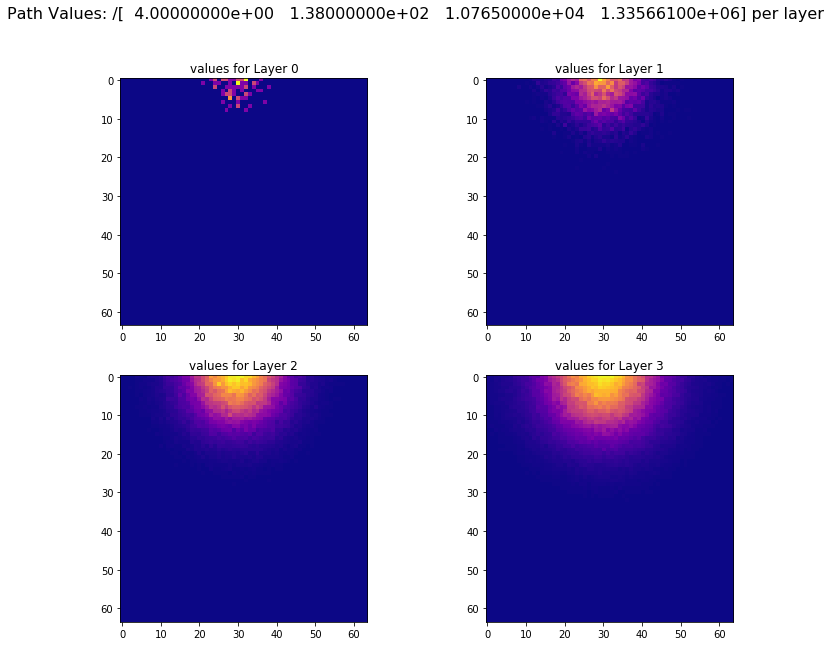

In [9]:
show_path_factor([-(128*60 + 4)])

## Single Stimuli

In [10]:
def paths_for_stimulus(stim_name, factor, length):
    this_one = all_filter[stim_name]
    threshold = this_one.filter_values.max()*0.1
    active_inputs = this_one[this_one.filter_values > threshold].ids.values
    
    colored = synapse_analysis.paths_to_neurons(active_inputs, synapses, factor, max_path_length=length)
    input_neurons, exc_neurons, inh_neurons = synapse_analysis.neuron_stats_to_layer(colored, 8, 128*128, network_architecture, "path_values")
    return exc_neurons
    

def show_path_from_stimulus(stim_name, factor, length):
    neuron_values = paths_for_stimulus(stim_name, factor, length)
    show_normalized(neuron_values)

/Users/clemens/.virtualenvs/myscipy/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


mean values per layer: [   24.50146484  4501.99560547     0.             0.        ]
Nonzero per layer: [ 638 1993    0    0]


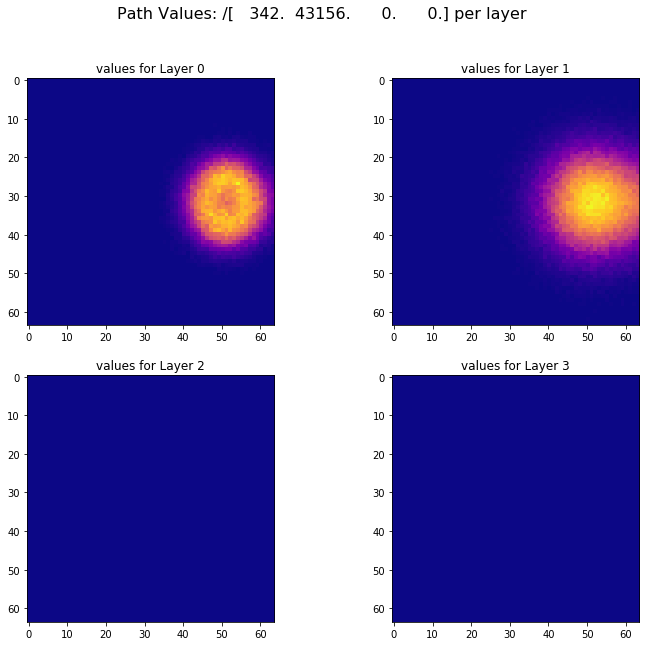

In [11]:
show_path_from_stimulus('2bdr', 1, 2)

mean values per layer: [  2.55722656e+01   4.59600098e+03   8.34593343e+05   1.51733558e+08]
Nonzero per layer: [ 623 2440 3920 4096]


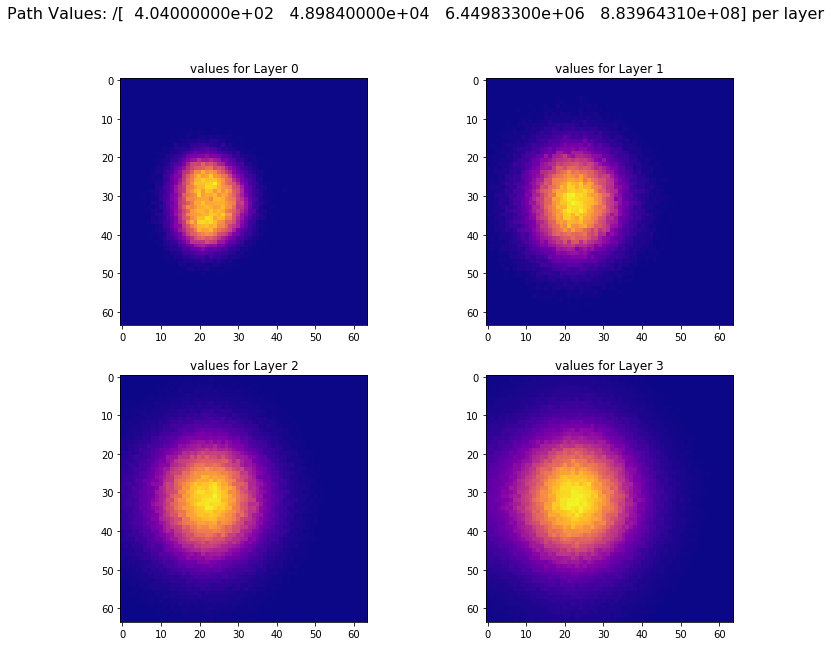

In [12]:
show_path_from_stimulus('1wcr', 1, 4)

## Overlap of Stimuli

In [13]:


def overlap_of_stimuli(stim_list, factor, length, overlap_function=np.min):
    paths_all_stimuli = np.concatenate([np.expand_dims(paths_for_stimulus(s, factor, length), 0) for s in stim_list], 0)
    # shape [stimulus, layer, neuron]
    overlap = overlap_function(paths_all_stimuli, axis=0)
    show_normalized(overlap)
    

/Users/clemens/.virtualenvs/myscipy/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


mean values per layer: [  1.09130859e-01   2.70441406e+02   0.00000000e+00   0.00000000e+00]
Nonzero per layer: [  0 984   0   0]


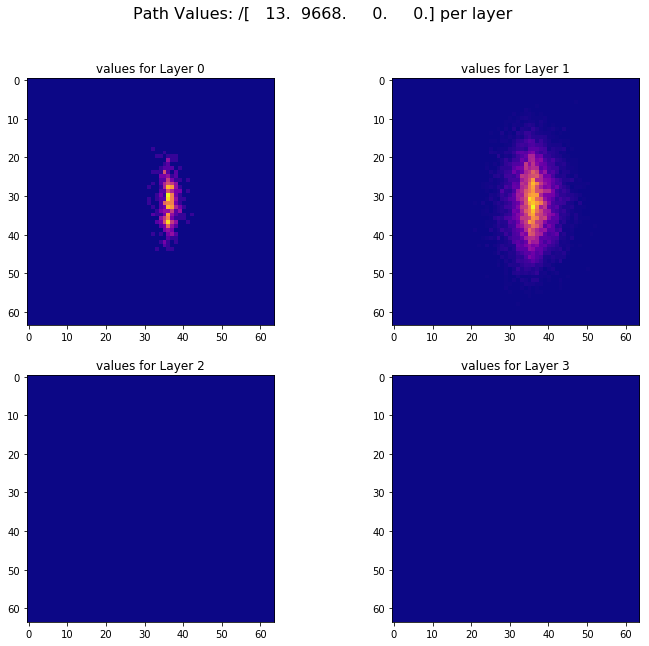

In [14]:
overlap_of_stimuli(['1bcr', '2bcr'], 1, 2)

mean values per layer: [  1.72673340e+01   3.47951758e+03   6.51523320e+05   1.19593036e+08]
Nonzero per layer: [ 545 1963 3270 4084]


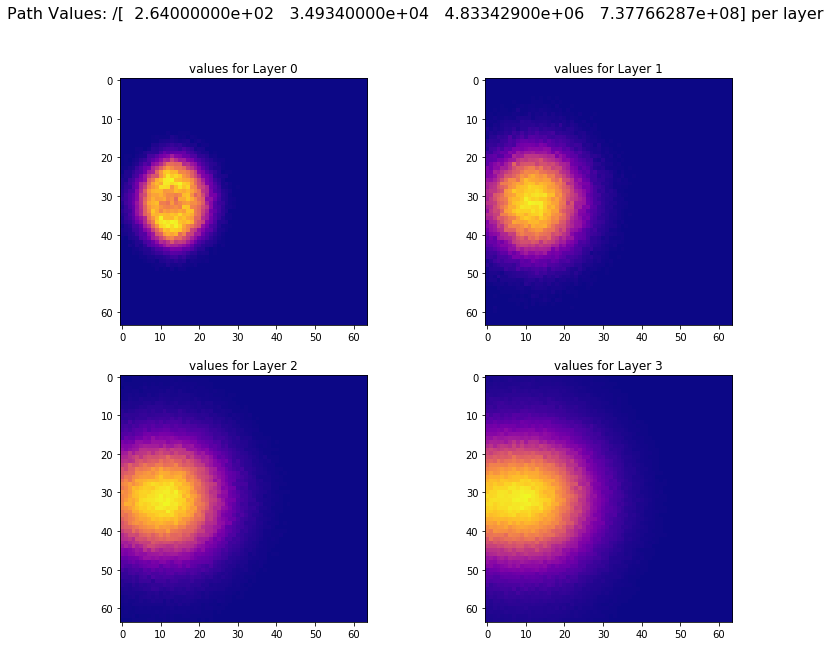

In [15]:
overlap_of_stimuli(['1bcl', '1wcl', '1bdl', '1wdl'], 1, 4)

/Users/clemens/.virtualenvs/myscipy/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


mean values per layer: [ 5.78662109  0.          0.          0.        ]
Nonzero per layer: [254   0   0   0]


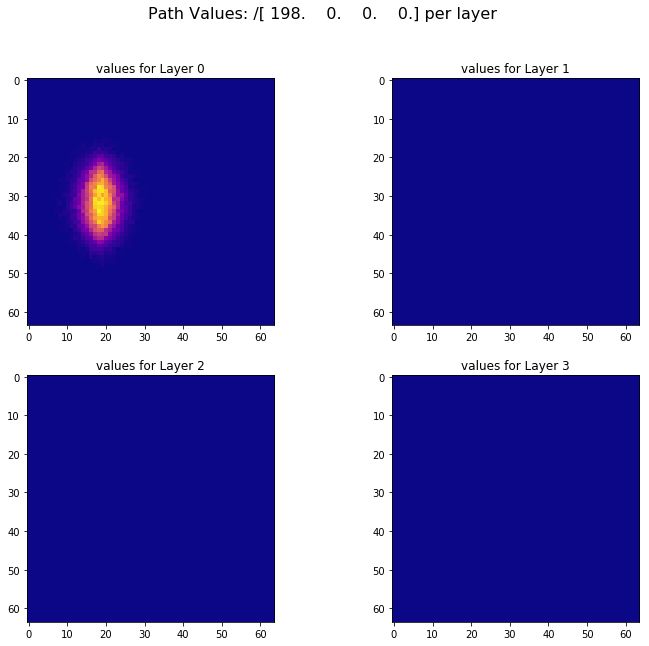

In [16]:
overlap_of_stimuli(['1bcr', '1wcr', '1bdr', '1wdr', '1bcl', '1wcl', '1bdl', '1wdl'], 1, 1)